In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt#visualization
import seaborn as sns
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import advertools as adv
from translate import Translator

In [2]:
#import data
Raw_Data = pd.read_csv(r"D:\\csit\\6th\\project\\analysis\\tweets.csv")
#select columns
tweets = Raw_Data[[ 'handle', 'text', 'is_retweet', 'original_author', 
                 'time', 'lang', 'retweet_count', 'favorite_count']] 
tweets.head()

,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
0,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,en,218,651
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,en,2445,5308
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,en,7834,27234
3,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,en,916,2542
4,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,en,859,2882


In [3]:
Raw_Data['word_count'] = Raw_Data['text'].apply(lambda x: len(str(x).split(" ")))
Raw_Data['char_count'] = Raw_Data['text'].str.len()

Text(0.5, 1.0, 'Raw Data Charcter Count')

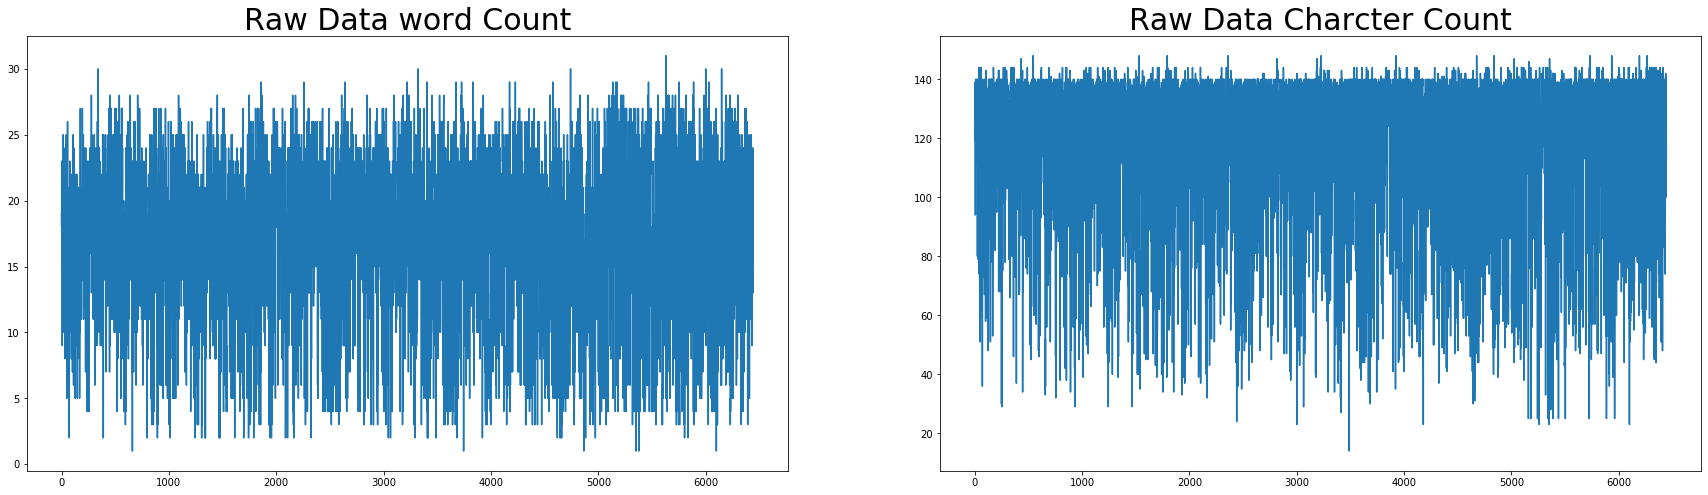

In [4]:
plt.figure(figsize=(30,8))
plt.subplot(121)
plt.plot(Raw_Data.word_count)
plt.title("Raw Data word Count",fontsize=30)
plt.subplot(122)
plt.plot(Raw_Data.char_count)
plt.title("Raw Data Charcter Count",fontsize=30)

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
Raw_Data['stopwords'] = Raw_Data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
Raw_Data[['text','stopwords']].head()

,text,stopwords
0,The question in this election: Who can put the...,8
1,"Last night, Donald Trump said not paying taxes...",3
2,Couldn't be more proud of @HillaryClinton. Her...,10
3,"If we stand together, there's nothing we can't...",4
4,Both candidates were asked about how they'd co...,5


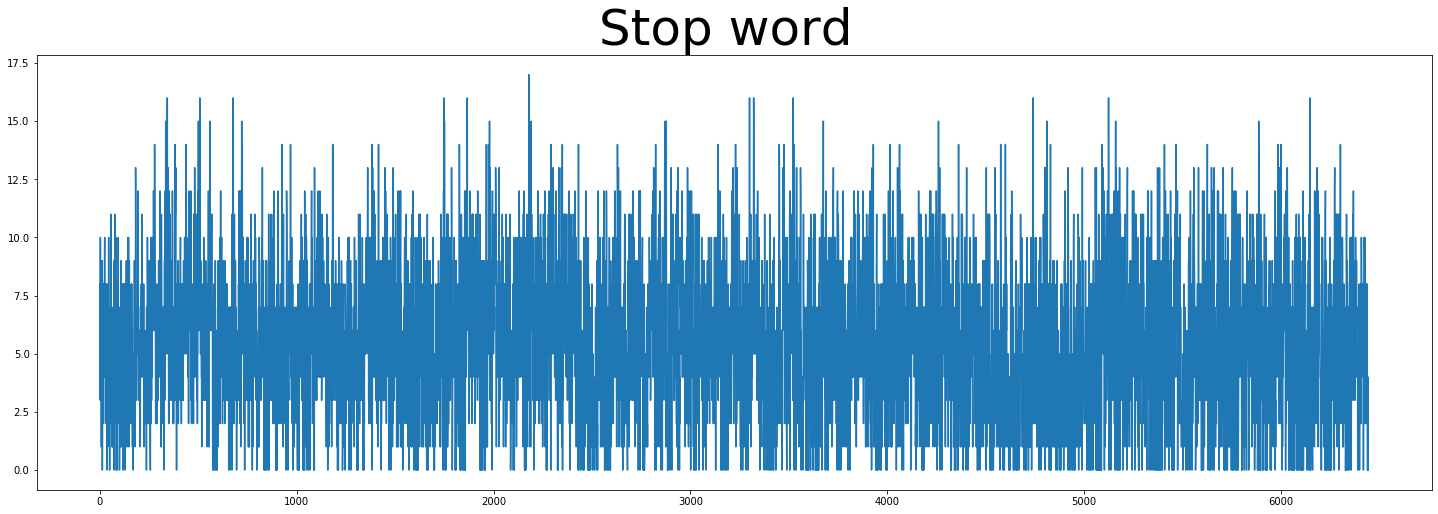

In [7]:
plt.figure(figsize=(25,8))
plt.title("Stop word ",fontsize=50)
plt.plot(Raw_Data.stopwords)

In [8]:
#convert to date format and extract hour
from datetime import datetime
date_format = "%Y-%m-%dT%H:%M:%S" 
tweets["time"]   = pd.to_datetime(tweets["time"],format = date_format)
tweets["hour"]   = pd.DatetimeIndex(tweets["time"]).hour
tweets["month"]  = pd.DatetimeIndex(tweets["time"]).month
tweets["day"]    = pd.DatetimeIndex(tweets["time"]).day
tweets["month_f"]  = tweets["month"].map({1:"JAN",2:"FEB",3:"MAR",
                                        4:"APR",5:"MAY",6:"JUN",
                                        7:"JUL",8:"AUG",9:"SEP"})


In [9]:
def label_language(tweets) :
    if tweets["lang"] == "en" :
        return "English"
    elif tweets["lang"]=="es" :
        return "Spanish"
    else:
        return "Other"
tweets["lang"] = tweets.apply(lambda tweets:label_language(tweets),axis = 1)

In [10]:
tweets['lang'].describe()

count        6444
unique          3
top       English
freq         6248
Name: lang, dtype: object

In [11]:
# translator= Translator(from_lang="spanish",to_lang="english")
# Language=tweets[tweets["lang"]=="Spanish"].text[:1].apply(lambda x: " ".join([translator.translate(word) for word in x.split()]))

In [12]:
#create new tweets column
tweets["tweets"] = tweets["text"]


In [13]:
#text manipulation
import  re
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [14]:
#function to remove special characters , punctions ,stop words ,
#digits ,hyperlinks and case conversion
def string_manipulation(df,column)  : 
    #extract hashtags
    df["hashtag"]  = df[column].str.findall(r'#.*?(?=\s|$)')
    #extract twitter account references
    df["accounts"] = df[column].str.findall(r'@.*?(?=\s|$)')
     #remove hashtags and accounts from tweets
    df[column] = df[column].str.replace(r'@.*?(?=\s|$)'," ")
    df[column] = df[column].str.replace(r'#.*?(?=\s|$)'," ")
    #convert to lower case
    df[column] = df[column].str.lower()
    #remove hyperlinks
    df[column] = df[column].apply(lambda x:re.split('https:\/\/.*',str(x))[0])
    #remove punctuations
    df[column] = df[column].str.replace('[^\w\s]'," ")
    #remove special characters
    df[column] = df[column].str.replace("\W"," ")
    #remove digits
    df[column] = df[column].str.replace("\d+"," ")
    #remove under scores
    df[column] = df[column].str.replace("_"," ")
    #remove stopwords
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_words)]))
    return df

tweets = string_manipulation(tweets,"text")


In [16]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
tweets['text']=tweets['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
from textblob import Word
tweets['text'] = tweets['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))



In [17]:

tweets_trump   = (tweets[(tweets["handle"] == "realDonaldTrump")].reset_index()
                  .drop(columns = ["index"],axis = 1))

tweets_hillary  = (tweets[(tweets["handle"] == "HillaryClinton") ].reset_index()
                              .drop(columns = ["index"],axis = 1))


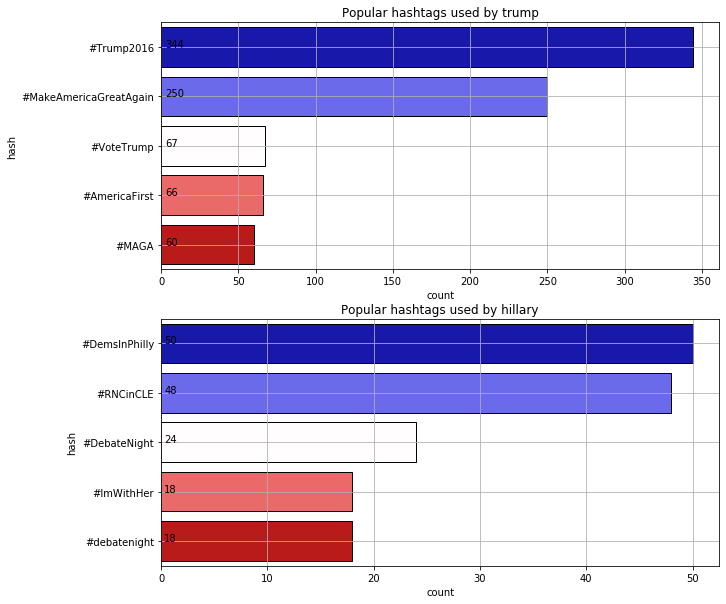

In [18]:
hashs_t = tweets_trump["tweets"].str.extractall(r'(\#\w+)')[0].value_counts().reset_index()
hashs_t.columns = ["hash","count"]

hashs_h = tweets_hillary["tweets"].str.extractall(r'(\#\w+)')[0].value_counts().reset_index()
hashs_h.columns = ["hash","count"]
plt.figure(figsize = (10,10))
plt.subplot(211)
ax = sns.barplot(x = "count" , y = "hash" ,
                 data = hashs_t[:5] , palette = "seismic",
                 linewidth = 1 , edgecolor = "k"* 5)
plt.grid(True)
for i,j in enumerate(hashs_t["count"][:5].values) :
    ax.text(3,i,j,fontsize = 10,color = "black")
plt.title("Popular hashtags used by trump")

plt.subplot(212)
ax1 = sns.barplot(x = "count" , y = "hash" ,
                 data = hashs_h[:5] , palette = "seismic",
                 linewidth = 1 , edgecolor = "k"* 5)
plt.grid(True)
for i,j in enumerate(hashs_h["count"][:5].values) :
    ax1.text(.3,i,j,fontsize = 10,color = "black")
plt.title("Popular hashtags used by hillary")
plt.show()

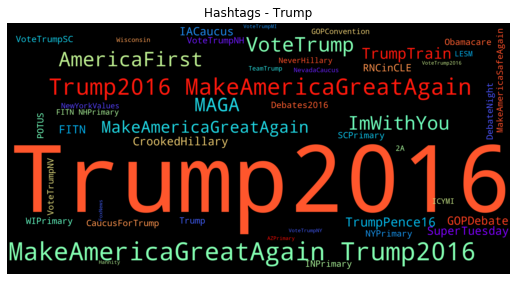

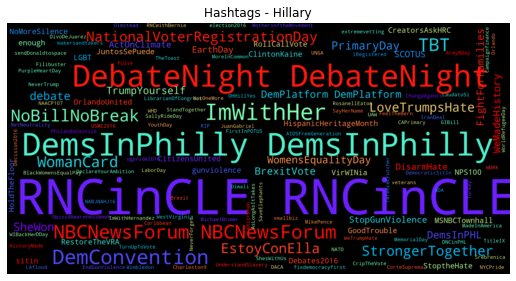

In [19]:
from wordcloud import WordCloud

hsh_wrds_t = tweets_trump["tweets"].str.extractall(r'(\#\w+)')[0]
hsh_wrds_h = tweets_hillary["tweets"].str.extractall(r'(\#\w+)')[0]

def build_word_cloud(words,back_color,palette,title) :
    word_cloud = WordCloud(scale = 7,max_words = 1000,
                           max_font_size = 100,background_color = back_color,
                           random_state = 0,colormap = palette
                          ).generate(" ".join(words))
    plt.figure(figsize=(9,9))
    plt.imshow(word_cloud,interpolation = "bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()



build_word_cloud(hsh_wrds_t,"black","rainbow","Hashtags - Trump")
build_word_cloud(hsh_wrds_h,"black","rainbow","Hashtags - Hillary")

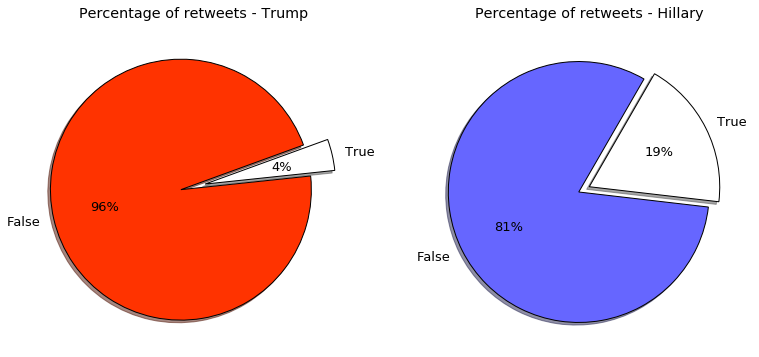

In [20]:
plt.style.use('ggplot')
plt.figure(figsize = (13,6))
plt.subplot(121)
tweets[tweets["handle"] ==
       "realDonaldTrump"]["is_retweet"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                                wedgeprops = {"linewidth" : 1,
                                                                              "edgecolor" : "k"},
                                                                shadow = True,fontsize = 13,
                                                                explode = [.1,0.09],
                                                                startangle = 20,
                                                                colors = ["#FF3300","w"]
                                                               )
plt.ylabel("")
plt.title("Percentage of retweets - Trump")

plt.subplot(122)
tweets[tweets["handle"] ==
       "HillaryClinton"]["is_retweet"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                                wedgeprops = {"linewidth" : 1,
                                                                              "edgecolor" : "k"},
                                                                shadow = True,fontsize = 13,
                                                                explode = [.09,0],
                                                                startangle = 60,
                                                                colors = ["#6666FF","w"]
                                                               )
plt.ylabel("")
plt.title("Percentage of retweets - Hillary")
plt.show()

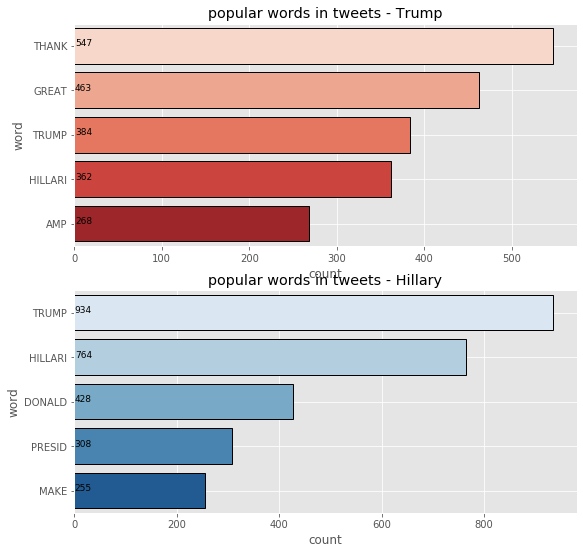

In [21]:
pop_wrds_t = (tweets_trump["text"].apply(lambda x : 
                                         pd.value_counts(x.split(" ")))
            .sum(axis = 0).reset_index().sort_values(by = [0],ascending = False))
pop_wrds_t.columns = ["word","count"]
pop_wrds_t["word"] = pop_wrds_t["word"].str.upper()

pop_wrds_d = (tweets_hillary["text"].apply(lambda x :
                                           pd.value_counts(x.split(" ")))
            .sum(axis = 0).reset_index().sort_values(by = [0],ascending = False))
pop_wrds_d.columns = ["word","count"]
pop_wrds_d["word"] = pop_wrds_d["word"].str.upper()

plt.figure(figsize = (9,9))
plt.subplot(211)
ax = sns.barplot(x = "count",y = "word",data = pop_wrds_t[:5],
                linewidth = 1 ,edgecolor = "k"*5,palette = "Reds")
plt.title("popular words in tweets - Trump")
plt.grid(True)
for i,j in enumerate(pop_wrds_t["count"][:5].astype(int)) :
    ax.text(.8,i,j,fontsize = 9)
    
plt.subplot(212)
ax1 = sns.barplot(x = "count",y = "word",data = pop_wrds_d[:5],
                linewidth = 1 ,edgecolor = "k"*5,palette = "Blues")
plt.title("popular words in tweets - Hillary")
plt.grid(True)
for i,j in enumerate(pop_wrds_d["count"][:5].astype(int)) :
    ax1.text(.8,i,j,fontsize = 9)

<Figure size 720x504 with 0 Axes>

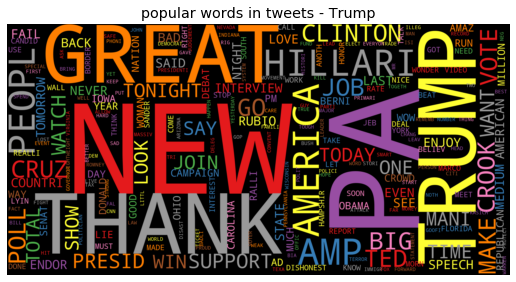

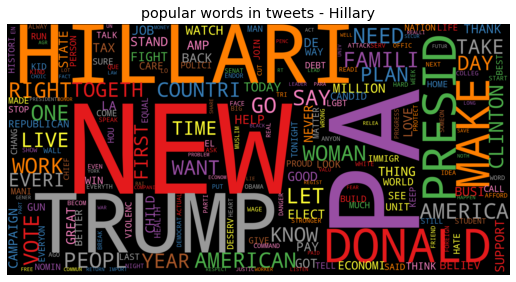

In [22]:
plt.figure(figsize=(10, 7))
build_word_cloud(pop_wrds_t["word"],"black","Set1","popular words in tweets - Trump")
build_word_cloud(pop_wrds_d["word"],"black","Set1","popular words in tweets - Hillary")

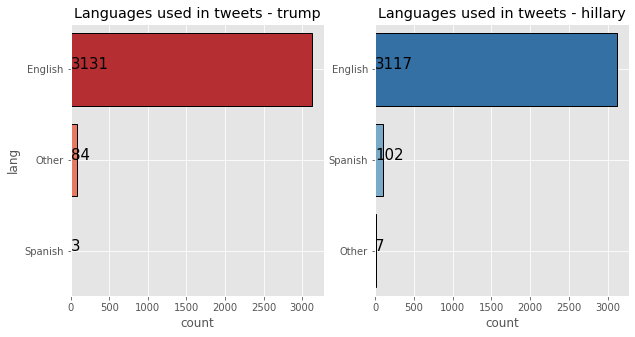

In [23]:
plt.figure(figsize = (10,5))

plt.subplot(121)
ax = sns.countplot(y = tweets[tweets["handle"] == "realDonaldTrump"]["lang"] ,
                   linewidth = 1,edgecolor = "k"*2,
                   palette = "Reds_r")

for i,j in enumerate(tweets[tweets["handle"] == 
                            "realDonaldTrump"]["lang"].value_counts().values) :
    ax.text(0.7,i,j,fontsize = 15)

plt.grid(True)
plt.title("Languages used in tweets - trump")
    
plt.subplot(122)
ax1 = sns.countplot(y = tweets[tweets["handle"] == "HillaryClinton"]["lang"] ,
                   linewidth = 1,edgecolor = "k"*2,
                    palette = "Blues_r")

for i,j in enumerate(tweets[tweets["handle"] == 
                            "HillaryClinton"]["lang"].value_counts().values) :
    ax1.text(.7,i,j,fontsize = 15)
    plt.grid(True)
plt.ylabel("")
plt.title("Languages used in tweets - hillary")
plt.show()

In [24]:
emoji_summary = adv.extract_emoji(Raw_Data['text'])
emoji_summary.keys()

dict_keys(['emoji', 'emoji_text', 'emoji_flat', 'emoji_flat_text', 'emoji_counts', 'emoji_freq', 'top_emoji', 'top_emoji_text', 'top_emoji_groups', 'top_emoji_sub_groups', 'overview'])

In [25]:
emoji_summary['overview']

{'num_posts': 6444,
 'num_emoji': 94,
 'emoji_per_post': 0.014587212911235258,
 'unique_emoji': 38}

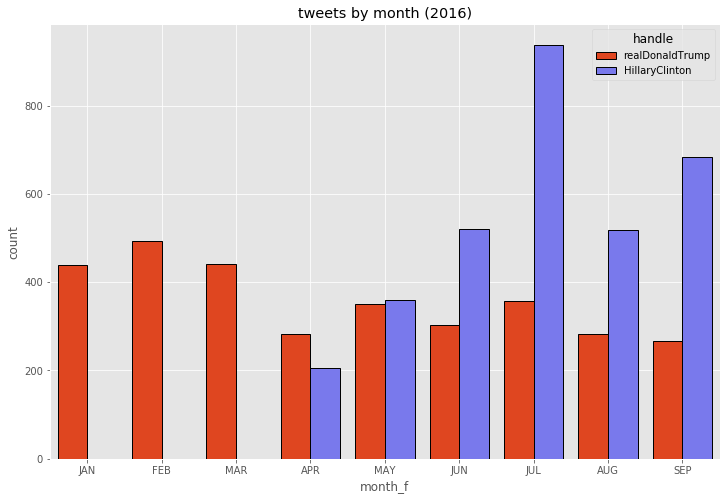

In [26]:
plt.figure(figsize = (12,8))
sns.countplot(x = "month_f",hue = "handle",palette = ["#FF3300","#6666FF"],
              data = tweets.sort_values(by = "month",ascending = True),
             linewidth = 1,edgecolor = "k"*tweets_trump["month"].nunique())
plt.grid(True)
plt.title("tweets by month (2016)")
plt.show()

In [28]:
#positive words
positive_words = pd.read_csv("D:\\csit\\6th\\project\\analysis\\positive-words.txt",
                             header=None,sep='delimiter')
# #negative words
negative_words = pd.read_csv("D:\\csit\\6th\\project\\analysis\\negative-words.txt",
                             header=None,encoding='latin-1',sep='delimiter')

#convert words to lists
def convert_words_list(df) : 
    words = string_manipulation(df,0)
    words_list = words[words[0] != ""][0].tolist()
    return words_list

positive_words_list = convert_words_list(positive_words)

#remove word trump from positive word list
positive_words_list = [i for i in positive_words_list if i not in "trump"]
negative_words_list = convert_words_list(negative_words)



c:\users\rabindra\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.

c:\users\rabindra\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [29]:
# function to score tweets based on positive and negative words present
def scoring_tweets(data_frame,text_column) :
    #identifying +ve and -ve words in tweets
    data_frame["positive"] = data_frame[text_column].apply(lambda x:" ".join([i for i in x.split() 
                                                                              if i in (positive_words_list)]))
    data_frame["negative"] = data_frame[text_column].apply(lambda x:" ".join([i for i in x.split()
                                                                              if i in (negative_words_list)]))
    #scoring
    data_frame["positive_count"] = data_frame["positive"].str.split().str.len()
    data_frame["negative_count"] = data_frame["negative"].str.split().str.len()
    data_frame["score"]          = (data_frame["positive_count"] -
                                    data_frame["negative_count"])
    
    #create new feature sentiment :
    #+ve if score is +ve , #-ve if score is -ve , # neutral if score is 0
    def labeling(data_frame) :
        if data_frame["score"]   > 0  :
            return "positive"
        elif data_frame["score"] < 0  :
            return "negative"
        elif data_frame["score"] == 0 :
            return "neutral"
    data_frame["sentiment"] = data_frame.apply(lambda data_frame:labeling(data_frame),
                                               axis = 1)
    return data_frame

In [30]:
tweets         = scoring_tweets(tweets,"text")
tweets_trump   = scoring_tweets(tweets_trump,"text")
tweets_hillary = scoring_tweets(tweets_hillary,"text")

tweets[["text","positive","negative","positive_count",
              "negative_count","score","sentiment"]].head(10)

,text,positive,negative,positive_count,negative_count,score,sentiment
0,question elect put plan action make life better,better,,1,0,1,positive
1,last night donald trump said pay tax smart kno...,smart,,1,0,1,positive
2,proud vision command last night debat show rea...,proud,,1,0,1,positive
3,stand togeth noth make sure readi vote,,,0,0,0,neutral
4,candid ask confront racial injust one real answer,,confront,0,1,-1,negative
5,join pm ralli tomorrow mid america center coun...,,,0,0,0,neutral
6,elect import sit go,,,0,0,0,neutral
7,donald trump goe low regist vote,,,0,0,0,neutral
8,govern peopl join movement today,,,0,0,0,neutral
9,trump offer singl propo reduc friction start busi,,friction,0,1,-1,negative


In [31]:
score_dist = tweets[tweets["is_retweet"] ==
                    False].groupby("handle")["score"].value_counts().to_frame()
score_dist.columns = ["count"]
score_dist = score_dist.reset_index().sort_values(by = "score",ascending = False)

trace = go.Bar(x = score_dist[score_dist["handle"] == "realDonaldTrump"]["score"],
               y = score_dist[score_dist["handle"] == "realDonaldTrump"]["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "red"),name = "Donald Trump"
              )

trace1 = go.Bar(x = score_dist[score_dist["handle"] == "HillaryClinton"]["score"],
                y = score_dist[score_dist["handle"] == "HillaryClinton"]["count"],
                marker = dict(line = dict(width = 1,color = "black"),
                             color = "blue"),name = "Hillary Clinton"
              )
layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )
fig = go.Figure(data = [trace,trace1],layout = layout)
py.iplot(fig)

In [32]:
sent_dist = pd.crosstab(tweets[tweets["is_retweet"] ==        
                            False]["sentiment"],
                        tweets[tweets["is_retweet"] ==
                               False]["handle"]).apply(lambda r:
                                                       r/r.sum()*100,axis = 0)

sent_dist = sent_dist.reset_index()
t1 = go.Bar(x = sent_dist["sentiment"],y = sent_dist["HillaryClinton"],
            name = "Hillary Clinton",
            marker = dict(line = dict(width = 1,color = "#000000"),color = "#6666FF"))

t2 = go.Bar(x = sent_dist["sentiment"],y = sent_dist["realDonaldTrump"],
           name = "Donald Trump",
           marker = dict(line = dict(width = 1,color = "#000000"),color = "#FF3300"))

layout = go.Layout(dict(title = "Sentiment distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2,title = "sentiment"),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2,title = "percentage"),
                        )
                  )

fig = go.Figure(data = [t1,t2],layout = layout)
py.iplot(fig)


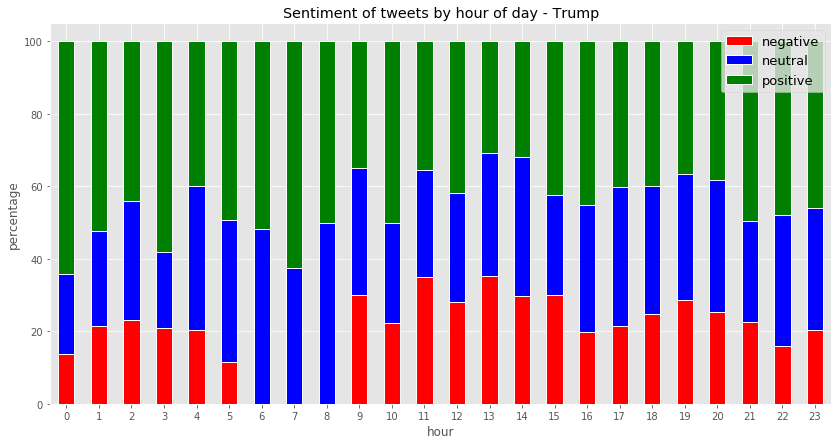

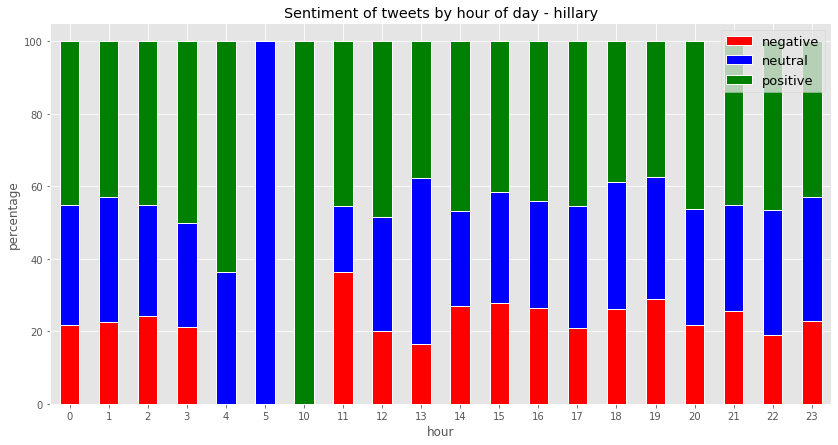

In [33]:
st_hr_t = pd.crosstab(tweets_trump["hour"],tweets_trump["sentiment"])
st_hr_t = st_hr_t.apply(lambda r:r/r.sum()*100,axis = 1)

st_hr_d = pd.crosstab(tweets_hillary["hour"],tweets_trump["sentiment"])
st_hr_d = st_hr_d.apply(lambda r:r/r.sum()*100,axis = 1)

st_hr_t.plot(kind = "bar",figsize = (14,7),color = ["r","b","g"],
              linewidth = 1,edgecolor = "w",stacked = True)
plt.legend(loc = "best",prop = {"size" : 13})
plt.title("Sentiment of tweets by hour of day - Trump")
plt.xticks(rotation = 0)
plt.ylabel("percentage")

st_hr_d.plot(kind = "bar",figsize = (14,7),color = ["r","b","g"],
              linewidth = 1,edgecolor = "w",stacked = True)
plt.legend(loc = "best",prop = {"size" : 13})
plt.title("Sentiment of tweets by hour of day - hillary")
plt.xticks(rotation = 0)
plt.ylabel("percentage")


plt.show()

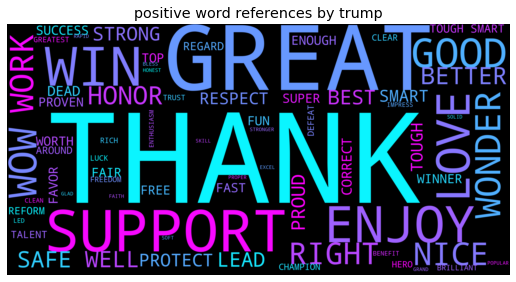

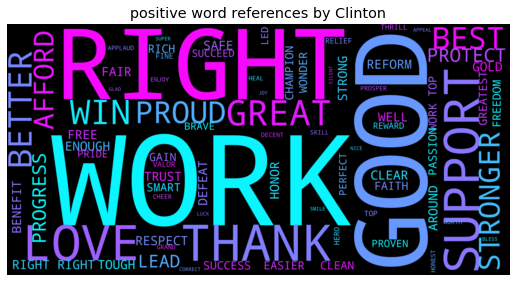

In [34]:
pw_t =  tweets_trump["positive"].str.split(expand = True).stack().reset_index()[0].str.upper()
pw_d =  tweets_hillary["positive"].str.split(expand = True).stack().reset_index()[0].str.upper()
build_word_cloud(pw_t,"black","cool","positive word references by trump")
build_word_cloud(pw_d,"black","cool","positive word references by Clinton")

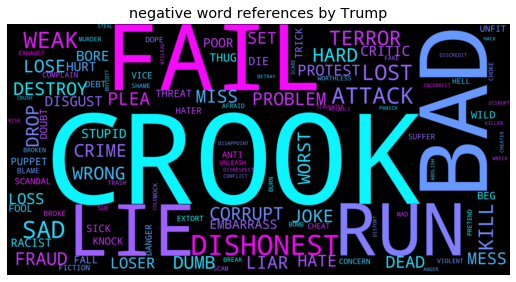

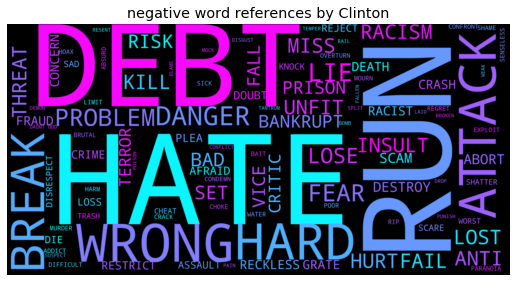

In [35]:
nw_t =  tweets_trump["negative"].str.split(expand = True).stack().reset_index()[0].str.upper()
nw_d =  tweets_hillary["negative"].str.split(expand = True).stack().reset_index()[0].str.upper()

build_word_cloud(nw_t,"black","cool","negative word references by Trump")
build_word_cloud(nw_d,"black","cool","negative word references by Clinton")

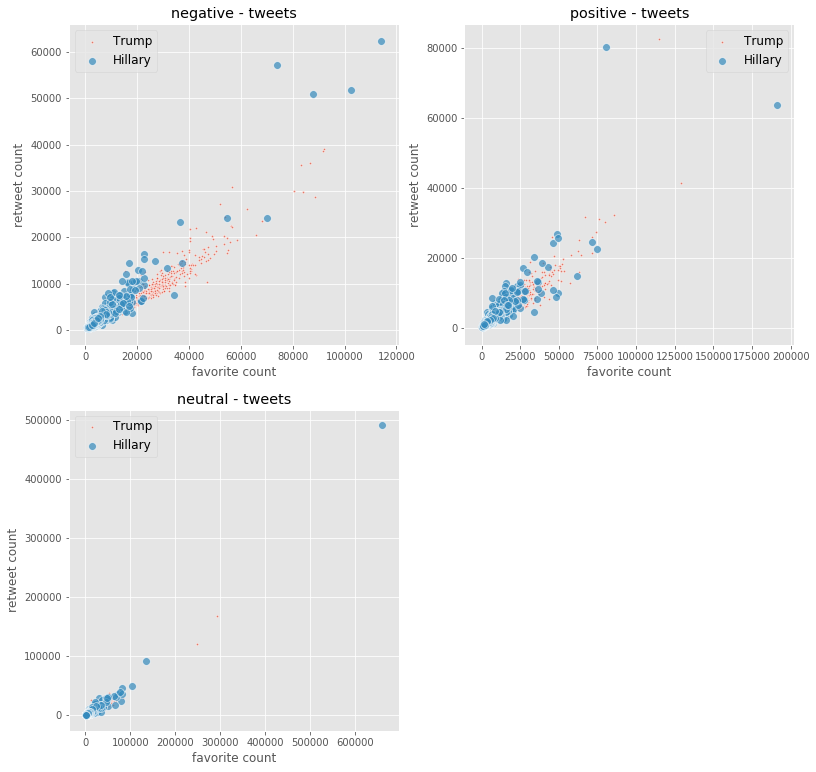

In [36]:
import itertools
lst =  ['negative', 'positive' ,'neutral']
cs  =  ["r","g","b"]

plt.figure(figsize = (13,13))

for i,j,k in itertools.zip_longest(lst,range(len(lst)),cs) :
    plt.subplot(2,2,j+1)
    plt.scatter(x = tweets_trump[tweets_trump["sentiment"] == i]["favorite_count"],
                y = tweets_trump[tweets_trump["sentiment"] == i]["retweet_count"],
                label = "Trump",linewidth = .7,edgecolor = "w",s = 6,alpha = .7)
    plt.scatter(x = tweets_hillary[tweets_hillary["sentiment"] == i]["favorite_count"],
                y = tweets_hillary[tweets_hillary["sentiment"] == i]["retweet_count"],
                label = "Hillary",linewidth = .7,edgecolor = "w",s = 60,alpha = .7)
    plt.title(i + " - tweets")
    plt.legend(loc = "best",prop = {"size":12})
    plt.xlabel("favorite count")
    plt.ylabel("retweet count")


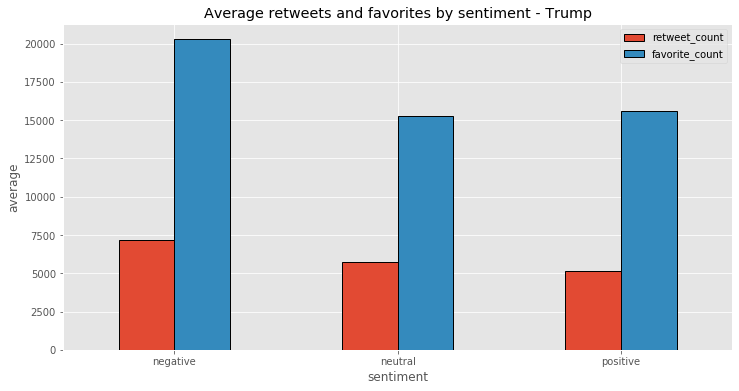

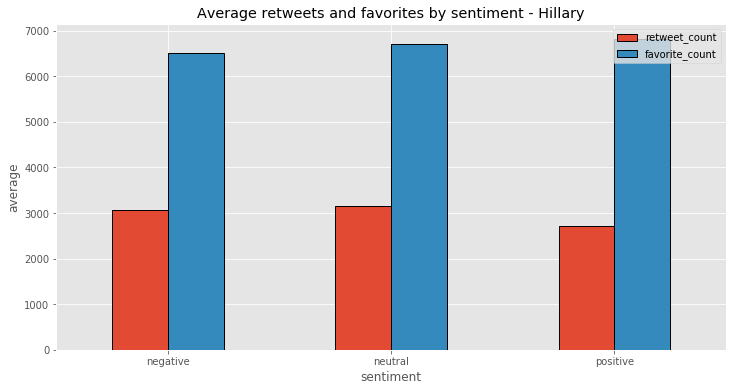

In [37]:
avg_fv_rts_t = tweets_trump.groupby("sentiment")[["retweet_count",
                                                "favorite_count"]].mean()
avg_fv_rts_h = tweets_hillary.groupby("sentiment")[["retweet_count",
                                                "favorite_count"]].mean()

avg_fv_rts_t.plot(kind = "bar",figsize = (12,6),linewidth = 1,edgecolor = "k")
plt.xticks(rotation = 0)
plt.ylabel("average")
plt.title("Average retweets and favorites by sentiment - Trump")

avg_fv_rts_h.plot(kind = "bar",figsize = (12,6),linewidth = 1,edgecolor = "k")
plt.xticks(rotation = 0)
plt.ylabel("average")
plt.title("Average retweets and favorites by sentiment - Hillary")
plt.legend()
plt.show()

In [38]:
tweets['text'] = tweets['text'].apply(lambda x: x.split())


In [39]:
clean_tweets=tweets[['handle','text','is_retweet','retweet_count','favorite_count','sentiment']]

In [40]:
clean_tweets.head()

,handle,text,is_retweet,retweet_count,favorite_count,sentiment
0,HillaryClinton,"[question, elect, put, plan, action, make, lif...",False,218,651,positive
1,HillaryClinton,"[last, night, donald, trump, said, pay, tax, s...",True,2445,5308,positive
2,HillaryClinton,"[proud, vision, command, last, night, debat, s...",True,7834,27234,positive
3,HillaryClinton,"[stand, togeth, noth, make, sure, readi, vote]",False,916,2542,neutral
4,HillaryClinton,"[candid, ask, confront, racial, injust, one, r...",False,859,2882,negative


In [41]:
clean_tweets.to_csv('process1_tweets.csv') 